# Filtering EEG signal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack, signal, stats
from pylsl import StreamInlet, resolve_stream

## Offline Filtering

In [2]:
# Read EEG signal from OpenBCI file
file = pd.read_csv(r'data/OpenBCI-sampleData-1-blinks-jawClench-alpha.txt', header = None) # sample file
file.columns = ['index','CH1','CH2','CH3', 'CH4','CH5','CH6','CH7','CH8', 'Aux1', 'Aux2', 'Aux3','-','Timestamps']

# Remove unused columns from dataframe
eeg_dataframe = pd.DataFrame(file)
eeg_dataframe.drop(['index', 'Aux1','Aux2','Aux3', '-'], axis=1, inplace=True)

# save to csv
eeg_dataframe.to_csv("data/OpenBCI-sampleData-1-blinks-jawClench-alpha.csv")

# Set time reference to 0 ms
eeg_dataframe['Timestamps'] = [float(data) - float(eeg_dataframe['Timestamps'][0]) for data in eeg_dataframe['Timestamps']]

# Set time in seconds
eeg_dataframe['Timestamps'] = np.divide(eeg_dataframe['Timestamps'], 1000)

eeg_dataframe

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,Timestamps
0,61379.36,49492.89,-16597.06,-21309.75,6703.91,-3284.86,7223.10,1740.11,0.000
1,60973.46,48972.47,-16279.02,-21050.13,7045.02,-2887.53,7593.09,2118.70,0.007
2,61433.45,49486.27,-16245.72,-20920.25,7035.70,-2916.12,7561.15,2090.85,0.007
3,61788.96,49917.57,-16488.30,-21147.99,6770.81,-3223.32,7286.27,1805.86,0.014
4,61512.69,49619.42,-16606.27,-21326.92,6676.73,-3309.31,7188.50,1709.48,0.014
...,...,...,...,...,...,...,...,...,...
22485,58750.42,47034.95,-18637.04,-27128.40,-9182.90,-18376.35,-5918.16,-6498.79,89.823
22486,59029.14,47391.53,-18737.73,-27217.09,-9327.85,-18544.50,-6069.39,-6654.94,89.823
22487,58890.72,47196.80,-18850.75,-27389.65,-9400.32,-18621.62,-6141.32,-6739.32,89.830
22488,58567.63,46769.70,-18777.12,-27361.26,-9255.01,-18427.36,-5976.43,-6570.79,89.837


In [3]:
# Constants
SAMPLING_RATE = 250.0 # assume OpenBCI sample rate
NYQUIST = SAMPLING_RATE/2.0
NO_CHANNEL = 'CH4'
CHANNEL = eeg_dataframe[NO_CHANNEL]
TIMESTAMP = eeg_dataframe['Timestamps']

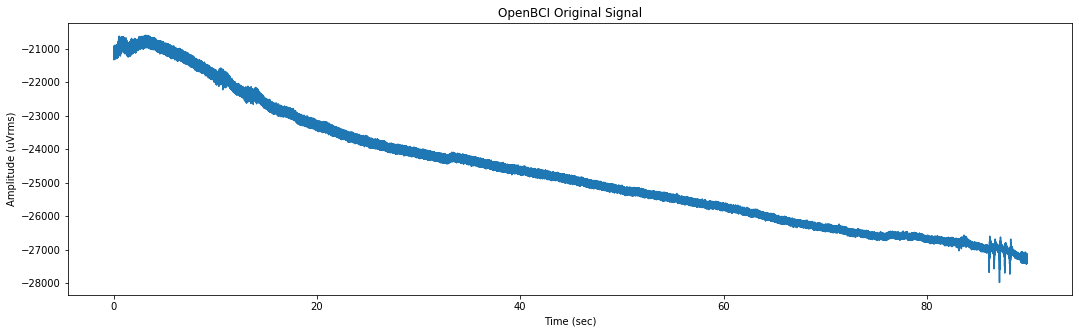

In [4]:
# Plot channel
plt.figure(figsize=(18.0, 5.0))
plt.title('OpenBCI Original Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (uVrms)')
plt.plot(TIMESTAMP, CHANNEL)

plt.show()

### Evaluate DC filter

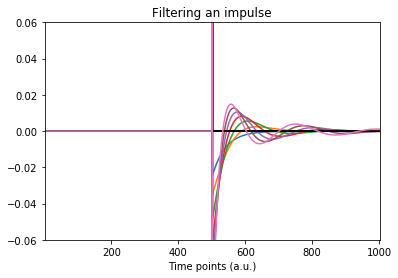

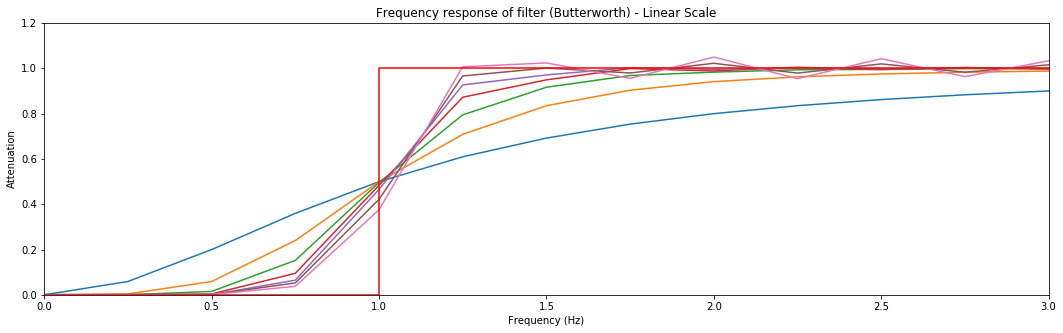

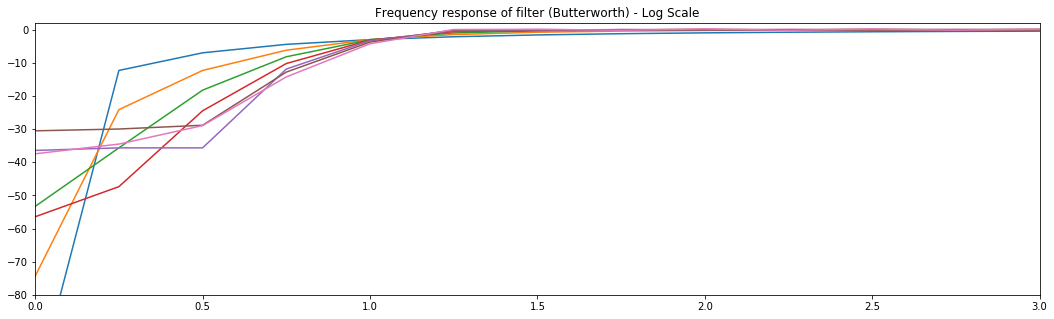

In [5]:
# orders to evaluate
orders_range = range(1,8);

# generate the impulse 
impulse_resp = np.zeros(1001)
impulse_resp[501] = 1

kernX = np.zeros((len(orders_range),1001))
hz = np.linspace(0,SAMPLING_RATE,1001)

# loop over orders
for order in range(0,len(orders_range)):

    # create filter coefficients
    b_kern_dc, a_kern_dc = signal.butter(orders_range[order], 1.0/NYQUIST, btype="highpass")
    n = len(b_kern_dc)
    
    # apply the filter to impulse
    filt_impulse = signal.lfilter(b_kern_dc,a_kern_dc,impulse_resp,axis=-1)
    
    # apply FFT to impulse
    kernX[order,:] = np.abs(fftpack.fft(filt_impulse))**2
    
    # plot the filter coefficient over time
    time = np.arange(0,len(b_kern_dc))/SAMPLING_RATE
    time = time - np.mean(time)
    
#     plt.subplot(131)
#     plt.plot(time,stats.zscore(b_kern_dc)+order)
#     plt.title('Filter coefficients (B)')
    
#     plt.subplot(132)
#     plt.plot(time,stats.zscore(a_kern_dc)+order)
#     plt.title('Filter coefficients (A)')
    
    # plot the impulse response
    plt.plot(impulse_resp,'k',label='Impulse')
    plt.plot(filt_impulse,label='Filtered')
    plt.xlim([1,len(impulse_resp)])
    plt.ylim([-.06,.06])
    plt.xlabel('Time points (a.u.)')
    plt.title('Filtering an impulse')

plt.show()

# plot the spectra
plt.figure(figsize=(18.0, 5.0))  # make new figure, set size in inches
plt.plot(hz,kernX.T)
plt.plot([0,1,1,NYQUIST],[0,0,1,1],'r')
plt.xlim([0,3])
plt.xlabel('Frequency (Hz)')
plt.ylim([0.0,1.2])
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth) - Linear Scale')

# in log space
plt.figure(figsize=(18.0, 5.0))  # make new figure, set size in inches
plt.plot(hz,10*np.log10(kernX.T))
plt.xlim([0,3])
plt.ylim([-80,2])
plt.title('Frequency response of filter (Butterworth) - Log Scale')
plt.show()

plt.show()

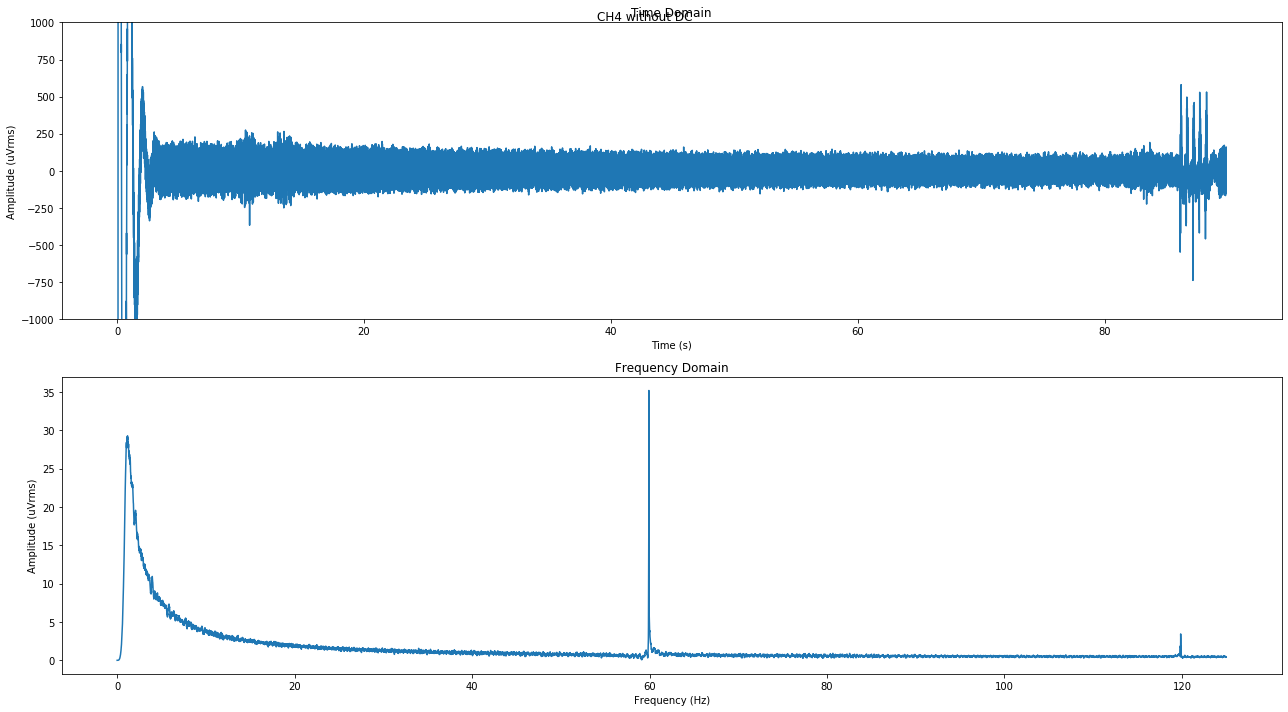

In [6]:
# Remove DC
b, a = signal.butter(5, 1.0/NYQUIST, 'highpass') # get coefficients
filtered_data = signal.lfilter(b, a, CHANNEL, 0) # apply filter to signal

# Apply FFT
fourier = fftpack.fft(filtered_data)/len(filtered_data) # apply FFT
fourier = fourier[range(int(len(filtered_data)/2))] # remove sampling frequency

nb_samples = len(filtered_data)
values = np.arange(int(nb_samples/2))
period = nb_samples/SAMPLING_RATE
frequencies = values/period

# Plot
fig, axis = plt.subplots(2, figsize=[18,10])
fig.suptitle(NO_CHANNEL + ' without DC')

axis[0].set_title('Time Domain')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude (uVrms)')
axis[0].set_ylim([-1000,1000])
axis[0].plot(TIMESTAMP, filtered_data)

axis[1].set_title('Frequency Domain')
axis[1].set_xlabel('Frequency (Hz)')
axis[1].set_ylabel('Amplitude (uVrms)')
axis[1].plot(frequencies, abs(fourier))

plt.tight_layout()
plt.show()

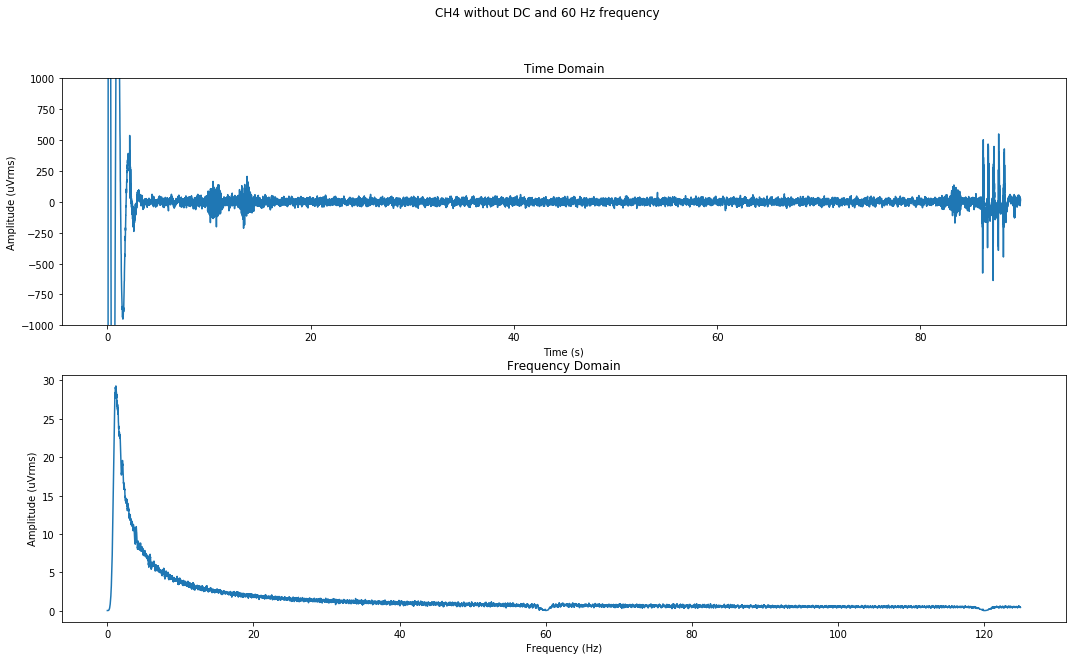

In [7]:
## Notch filters

# Remove 60 Hz
stop_filter_sx = np.array([59.0, 61.0])
b, a = signal.butter(2,stop_filter_sx/NYQUIST, 'bandstop')
filtered_data_2 = signal.lfilter(b,a,filtered_data)

# Remove 120 Hz harmonic
stop_filter_harmonic = np.array([119.0, 121.0])
d, c = signal.butter(2,stop_filter_harmonic/NYQUIST, 'bandstop')
filtered_data_3 = signal.lfilter(d,c,filtered_data_2)

# Apply FFT
fourier = fftpack.fft(filtered_data_3)/len(filtered_data_3) # apply FFT
fourier = fourier[range(int(len(filtered_data_3)/2))] # remove sampling frequency

## Plot
fig, axis = plt.subplots(2, figsize=[18,10])
fig.suptitle(NO_CHANNEL + ' without DC and 60 Hz frequency')

axis[0].set_title('Time Domain') 
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude (uVrms)')
axis[0].set_ylim([-1000,1000])
axis[0].plot(TIMESTAMP, filtered_data_3)

axis[1].set_title('Frequency Domain')
axis[1].set_xlabel('Frequency (Hz)')
axis[1].set_ylabel('Amplitude (uVrms)')
axis[1].plot(frequencies, abs(fourier))

plt.show()

### Save filtered data to .csv file

In [8]:
filt_eeg = pd.DataFrame(filtered_data_3)
filt_eeg.to_csv("data/filtered_"+NO_CHANNEL+".csv")

### Testing IIR Bandpass Filters

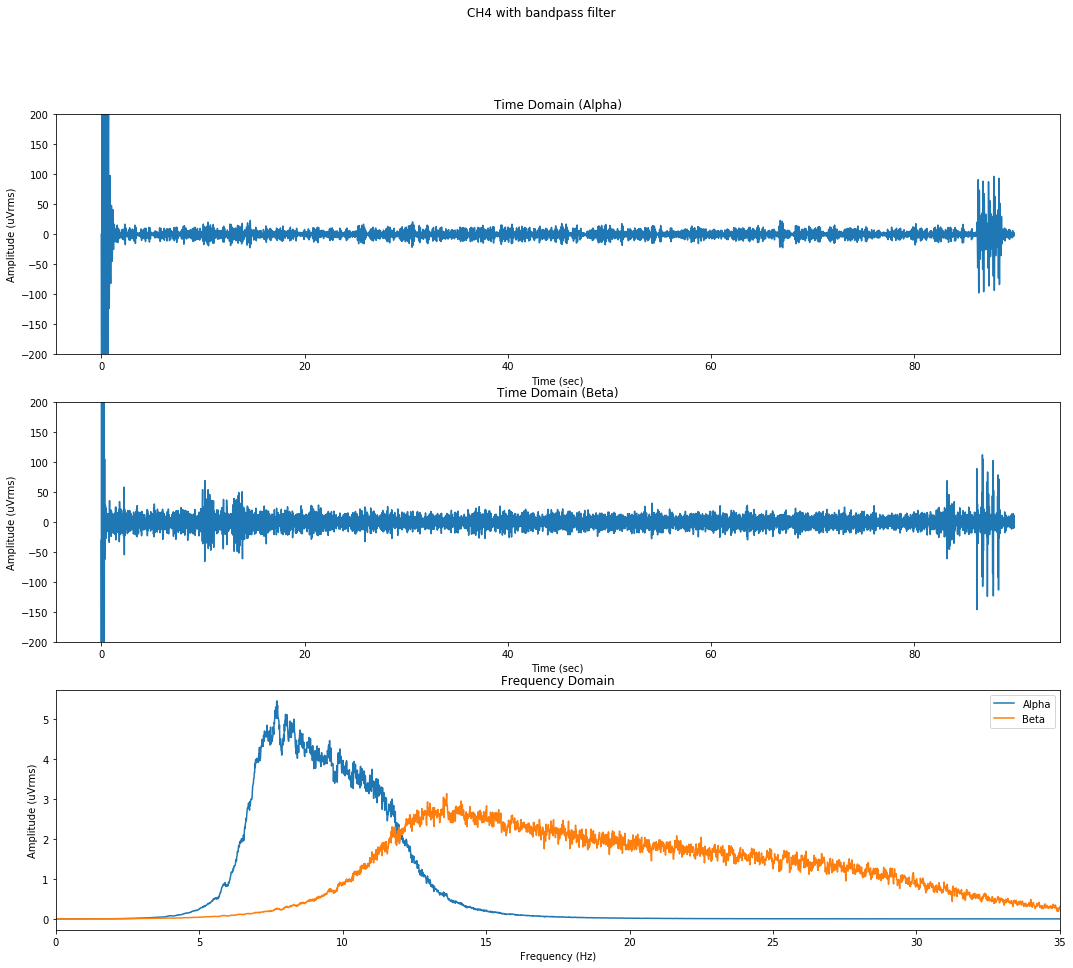

In [9]:
# Create and Apply Alpha bandpass filter
alpha_range = np.array([7.0,12.0])
b, a = signal.butter(4,alpha_range/NYQUIST,'bandpass')
eeg_alpha_band = signal.lfilter(b,a,filtered_data_2,0)

# Create and Apply Beta bandpass filter
beta_range = np.array([12.0,30.0])
d, c = signal.butter(4,beta_range/NYQUIST,'bandpass')
eeg_beta_band = signal.lfilter(d,c,filtered_data_2,0)

# Apply FFT (alpha band)
fourier_alpha = fftpack.fft(eeg_alpha_band)/len(eeg_alpha_band)
fourier_alpha = fourier_alpha[range(int(len(fourier_alpha)/2))] # Remove sampling frequency

# Apply FFT (beta band)
fourier_beta = fftpack.fft(eeg_beta_band)/len(eeg_beta_band)
fourier_beta = fourier_beta[range(int(len(fourier_beta)/2))] # Remove sampling frequency

# Plot
fig, axis = plt.subplots(3, figsize=[18,15])
fig.suptitle(NO_CHANNEL + ' with bandpass filter')

axis[0].set_title('Time Domain (Alpha)')
axis[0].set_ylim(-200, 200)
axis[0].set_ylabel('Amplitude (uVrms)')
axis[0].set_xlabel('Time (sec)')
axis[0].plot(TIMESTAMP, eeg_alpha_band)

axis[1].set_title('Time Domain (Beta)')
axis[1].set_ylim(-200, 200)
axis[1].set_ylabel('Amplitude (uVrms)')
axis[1].set_xlabel('Time (sec)')
axis[1].plot(TIMESTAMP, eeg_beta_band)

axis[2].set_title('Frequency Domain')
axis[2].set_xlim(0,35)
axis[2].set_ylabel('Amplitude (uVrms)')
axis[2].set_xlabel('Frequency (Hz)')
axis[2].plot(frequencies, abs(fourier_alpha), label='Alpha')
axis[2].plot(frequencies, abs(fourier_beta), label='Beta')
axis[2].legend()

plt.show()

## Real-time Filtering

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


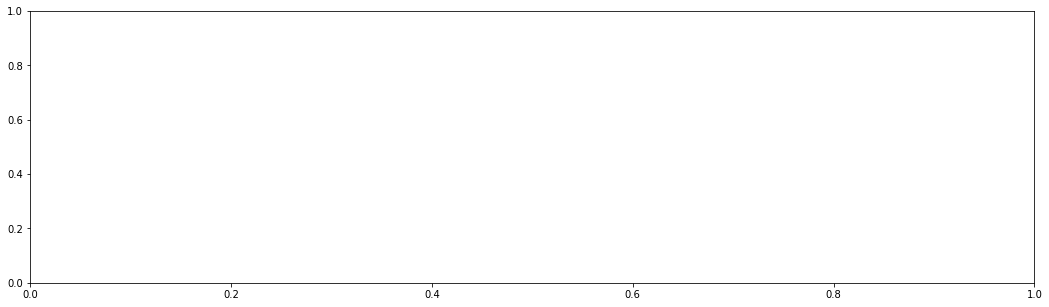

In [10]:
plt.rcParams['animation.html'] = 'jshtml'

fig = plt.figure(figsize=(18.0, 5.0))
ax = fig.add_subplot(1,1,1)
fig.show()

In [11]:
# # first resolve an EEG stream on the lab network
# print("looking for an EEG stream...")
# streams = resolve_stream('type', 'EEG')

# # create a new inlet to read from the stream
# inlet = StreamInlet(streams[0])

# i = 0
# data, time = [], []

# while True:
#     sample, timestamp = inlet.pull_sample() # sample[0] for channel 1, sample[1] for channel 2, etc. 

#     ax.plot(time,data, color='b')
#     fig.canvas.draw() # update figure
#     ax.set_xlim(left=max(0,i-50), right=i+50) # to move display window
#     i += 1
#     time.sleep(?)

# Testing MNE

In [12]:
import os
import mne

In [13]:
# get data from one channel
data = np.genfromtxt("data/filtered_"+NO_CHANNEL+".csv",delimiter=',')
data_channel = np.array([data[:,1]])
ch_types = ['eeg']
ch_names = [NO_CHANNEL]
data_channel

array([[ 0.00000000e+00, -1.90565571e+04, -1.85333163e+04, ...,
         2.66600444e+01,  1.45976735e+01,  9.00413683e+00]])

In [14]:
# create info object
info = mne.create_info(ch_names=ch_names, sfreq=SAMPLING_RATE, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: CH4
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>

Creating RawArray with float64 data, n_channels=1, n_times=22491
    Range : 0 ... 22490 =      0.000 ...    89.960 secs
Ready.
Using matplotlib backend: MacOSX


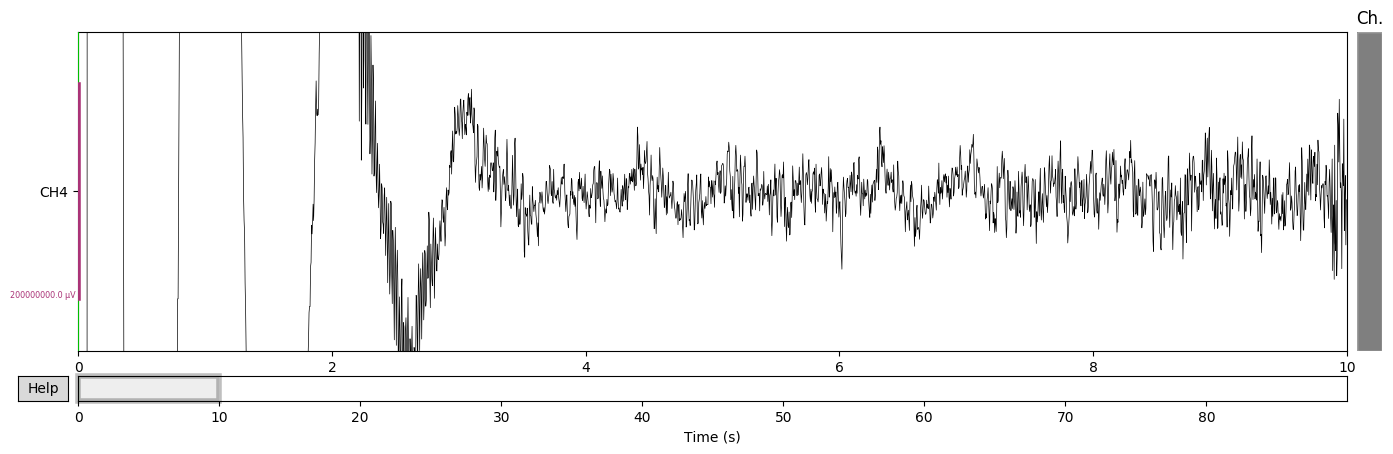

In [15]:
# create Raw object
raw = mne.io.RawArray(data_channel, info)

# plot outside notebook
%matplotlib
scaling = 100
raw.plot(n_channels=1, scalings=scaling)

### Divide data into equal epoch

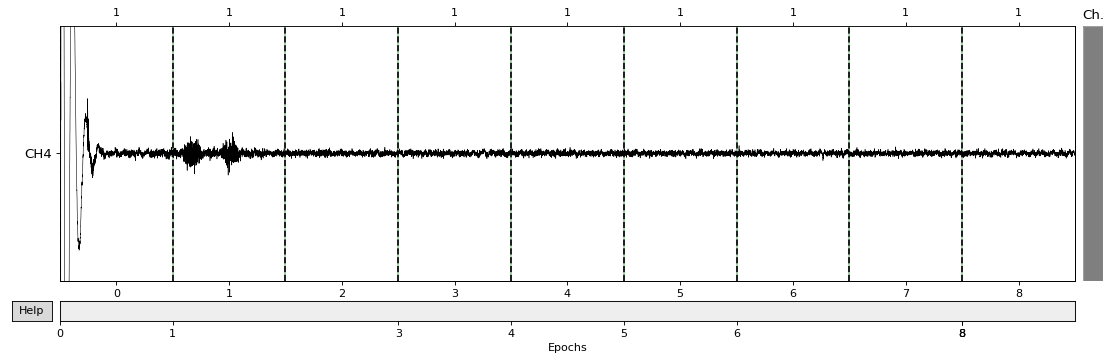

In [16]:
event_id = 1
duration = 9.

epochs = mne.make_fixed_length_epochs(raw,duration=duration,verbose=False)
epochs.plot(scalings=scaling)

# events = mne.make_fixed_length_events(raw, event_id, duration)
# # create :class:`Epochs <mne.Epochs>` object
# epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None, verbose=False)
# epochs.plot(scalings=scaling)